
# Deutsch–Jozsa Algorithm Implementation with Qiskit

## 1: The Problem
**Input:** Given an oracle function $f: \{0,1\}^n → \{0,1\}$, where $n$ is the number of bits.  

**Objective:** Output whether the oracle function $f$ is constant or balanced.

#### Classical Solution
In the classical implementation, the worst-case scenario needs $2^{n-1} + 1$ passes through the oracle to determine the type of function. The worst case complexity is driven by the case of having all half of the balanced inputs being tested first. The classical algorithm might need to evaluate the function for approximately half of the possible inputs to be sure that it's a constant or a balanced function.
<br>
#### Quantum Solution (Deutsch–Jozsa Algorithm)
The Deutsch–Jozsa algorithm allows us to solve this problem with only a single pass of the oracle. The algorithm puts every qubit into a superposition with Hadamard gates. Any entanglement within the oracle will be displayed in the inputs after they pass through the oracle.

In [4]:
import qiskit
from qiskit.visualization import plot_bloch_multivector 
import numpy as np
import pylatexenc 
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator

## 2: Classical Circuit Implementation

In [7]:
# Function to automatically instantiate the oracle circuit 
def balancedOracle(circuit):
    circuit.barrier()
    circuit.x([0,2])
    circuit.cx([0,2] , 3)
    circuit.x([0,2])
    circuit.barrier()
    return circuit

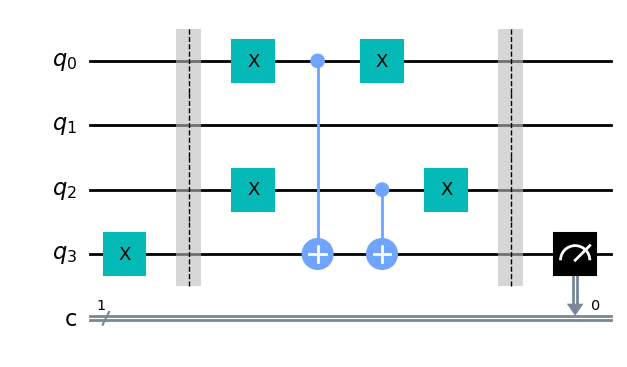

In [9]:
# number of qubits
n = 3

# initialize circuit
classicalCircuit = QuantumCircuit(n+1,1)

# add not gate to output bit
classicalCircuit.x(n)
# add the oracle to the circuit
classicalCircuit = balancedOracle(classicalCircuit)
# measure the output bit after the oracle
classicalCircuit.measure(n, 0)

display(classicalCircuit.draw('mpl'))

We can see that the qubits q₀ to q₂ are acting as our classical inputs into the oracle function. Our q3 bit's value will be modified based on these inputs to return the output of the function. 

**Constant Function:** A constant function will always return entirely 0's or entirely 1's no matter the input. When thinking about the implementation of this function. I like to think of the output value as completely independent and not correlated to the input values of the function. 

**Balanced Function:** On the contrary, balanced functions will be dependent and correlated to the input values. Correlation between quantum bits is created with entanglement which we can replicate with the cnot gate. This is the oracles way of changing the output value based on the input values. 

A classical computer in it's worst case would have to pass through the oracle with the given complexity to determine whether the oracle is balanced or constant: $2^{n-1} + 1$

It is fairly intuitive if you work through a visualization. You have a black box that you input random numbers and it gives out an output. In your brute force method of typing in every output, you theoretically need to try at least half of the possible inputs + 1. You could get the exact same output for half of the possibilities and if the value after the half way point is the same as the initial outputs, that means that the function must be constant. 

Lets create a table visualizing the inputs and outputs of this oracle to confirm that it's balanced:

### Table Visualization
| **Inputs**  | 000 | 001 | 010 | 011 | 100 | 101 | 110 | 111 |
|-------------|-----|-----|-----|-----|-----|-----|-----|-----|
| **Outputs** | 1   | 0   | 1   | 0   | 0   | 1   | 0   | 1   |


## 3: Quantum Circuit Implementation

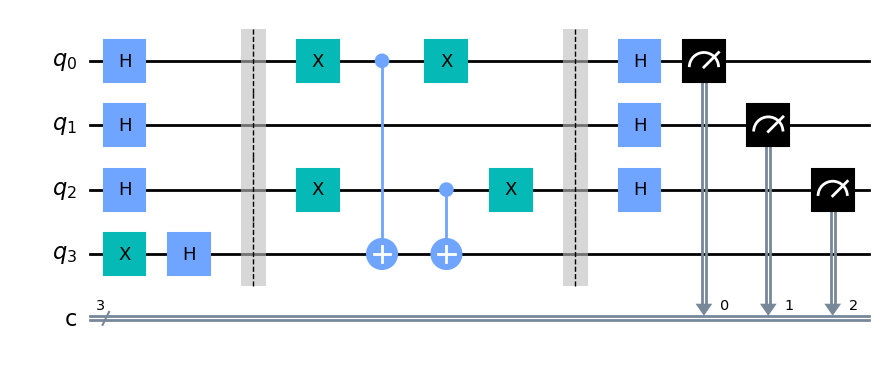

In [15]:
# initialize circuit
dj_Circuit = QuantumCircuit(n+1, n)

# add not gate to the output qubit
dj_Circuit.x(n)
# add hadamard gates to all qubits
dj_Circuit.h(range(n+1))
# add the oracle to the circuit
dj_Circuit = balancedOracle(dj_Circuit)
# finish the "hadamard sandwich" by applying hadamards to the input qubits
dj_Circuit.h(range(n))
# measure the values of the input qubits
dj_Circuit.measure(range(n), range(n))

display(dj_Circuit.draw('mpl'))

To implement the Deutsch-Jozsa Algorithm, we need to place q₀ to q₃ into superposition with the Hadamard gate. This, in a way, gives the oracle a superposition of every possible variation as an input. Before the quantum states enter the oracle, q₀ to q₂ will be in the state |+⟩, while q₃ is in the quantum state |-⟩.

$$ |+\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle) $$

$$ |-\rangle = \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle) $$

Within the oracle, if any of the inputs are manipulating the output value, q₃, we know that it will be using the cnot gate. This swaps the value of the target bit if the control bit is 1. Another more hidden feature of this cnot gate is quantum phase kickback, which transfers the phase of the target qubit to the control qubit. This transfer of information is the key piece of the functionality of the Deutsch-Jozsa algorithm. This transfer of information changes the state of the input qubit which will reveal itself in the values of the circuit.

*Note: The quantum circuit does not measure the output qubit. This is because we are measuring the values of the inputs after flowing through the circuit. The output qubit returns the same data as a classical circuit. Basing our solution off of the measurement of the output qubit would lead us to an identical classical solution.*

### 3.1: Quick Example of Quantum Phase Kickback

For instance, if q₀ is the control bit and q₃ is our target bit. Here are the states of both qubits before they pass through the cnot gate:
$$ q₀ = |+\rangle $$
$$ q₃ = |-\rangle $$
Here are there values after the cnot gate:
$$ q₀ = |-\rangle $$
$$ q₃ = |-\rangle $$

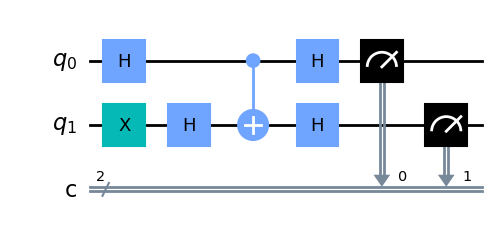

In [27]:
# initialize circuit
phaseKickback = QuantumCircuit(2,2)

# create superposition states
phaseKickback.x(1)
phaseKickback.h(range(2))
# entangle states
phaseKickback.cx(0,1)
phaseKickback.h(range(2))
# measure
phaseKickback.measure(range(2), range(2))

display(phaseKickback.draw('mpl'))

{'11': 1024}


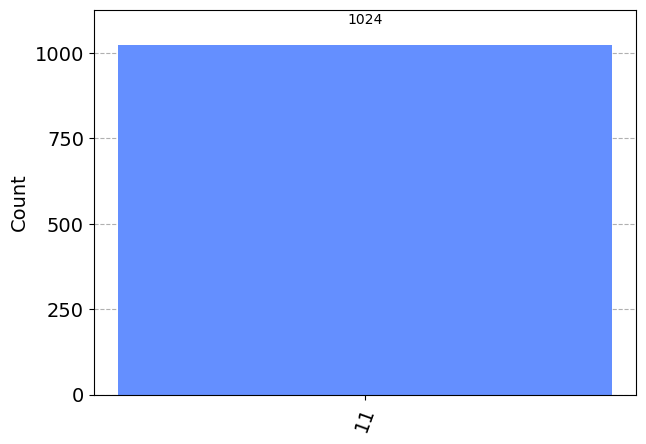

In [20]:
# simulate outputs
sim = AerSimulator()
compiled = transpile(phaseKickback, sim)
job = assemble(compiled)

result = sim.run(compiled).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)


As we can see q₀ starts in state |0⟩ and for some reason collapses into the state |1⟩ after the circuit is measured. This shows the effects of quantum phase kickback on the outputs of the circuit. 

### 3.2: Back to the Deutsch-Jozsa Algorithm

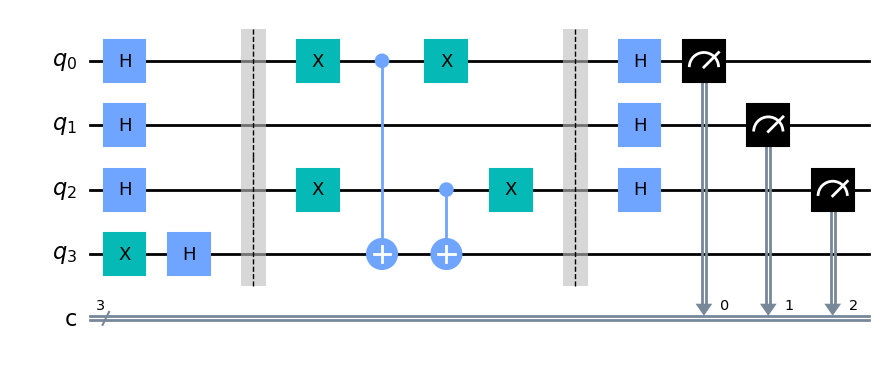

In [21]:
display(dj_Circuit.draw('mpl'))

{'101': 1024}


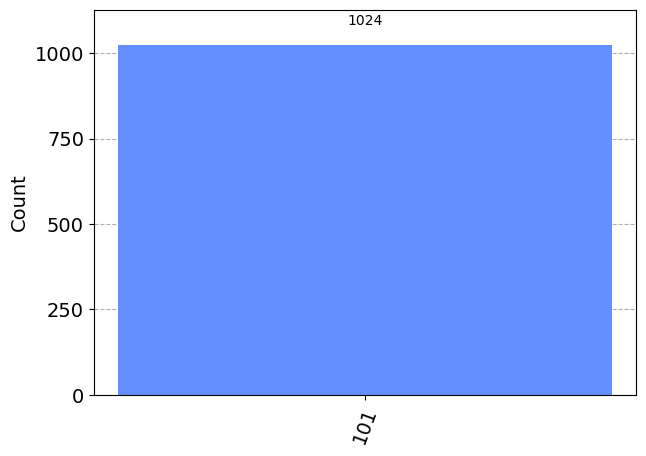

In [28]:
# simulate algorithm circuit
compiled = transpile(dj_Circuit, sim)
job = assemble(compiled)

result = sim.run(compiled).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

The existence of any input qubits changing values displays that this function is balanced. The input bits remaining 0 will communicate that the function is constant. This is how a quantum circuit can show whether a function is constant or balanced based on a single pass of the function.  

## Conclusion
When we measure the states of the input qubits q₃-q₀, we notice that instead of returning the original inputs like they would in a classical circuit, the inputs changed. This change in value is from the quantum phase kickback changing 2 of the qubits from the states |+⟩ to |-⟩. When |-⟩ passes through a hadamard gate, it collapses to the value 1 which is what we see here. The quantum phase kickback gives us a small insight into the inside of this oracle and how it is effecting the output qubit.